<a href="https://colab.research.google.com/github/vldzmtnsdl/ESAA-/blob/ESAA/1011_%EC%84%B8%EC%85%98%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

amazon reviews를 이용한 추천시스템 실습

In [4]:
pip install IPython


In [5]:
import IPython
from IPython import *

In [6]:
import numpy as np
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [8]:
electronics_data = pd.read_csv("/content/drive/MyDrive/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [9]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [10]:
electronics_data.shape

(7824482, 4)

In [11]:
electronics_data=electronics_data.iloc[:1048576,0:]

In [12]:
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [13]:
electronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [14]:
print("max of rating : %d" %(electronics_data.Rating.max()))
print("min of rating : %d" %(electronics_data.Rating.min()))

max of rating : 5
min of rating : 1


In [15]:
print('Number of missing values across columns:\n',electronics_data.isnull().sum())

Number of missing values across columns:
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


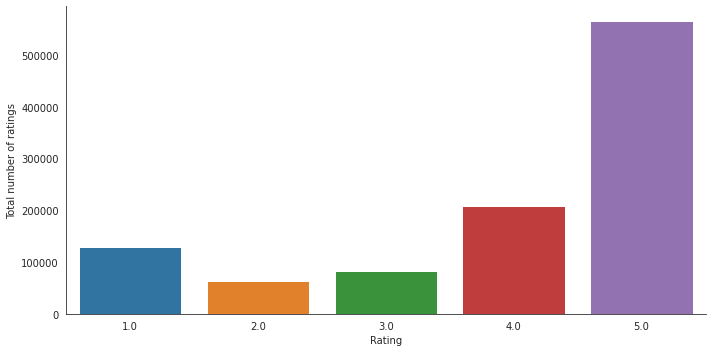

In [16]:
with sns.axes_style('white'):
  g=sns.factorplot("Rating",data=electronics_data,
                   aspect=2.0,kind='count')
  g.set_ylabels("Total number of ratings")

In [17]:
print("Total data")
print("-"*50)
print('\nTotal num of ratings:',electronics_data.shape[0])
print('Total num of Users:',len(np.unique(electronics_data.userId)))
print('Total num of products:',len(np.unique(electronics_data.productId)))

Total data
--------------------------------------------------

Total num of ratings: 1048576
Total num of Users: 786330
Total num of products: 61894


In [18]:
electronics_data.drop(['timestamp'],axis=1,inplace=True)

In [19]:
electronics_data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


ratings 분석

In [20]:
num_of_rated_products_per_user=electronics_data.groupby(
    by='userId')['Rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [21]:
num_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [22]:
#거의 모든 유저들이 하나의 아이템에만 평가...?

In [23]:
num_of_rated_products_per_user[num_of_rated_products_per_user>=2].count()

136821

In [24]:
786330/136821

5.747144078759839

In [25]:
quantiles=num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

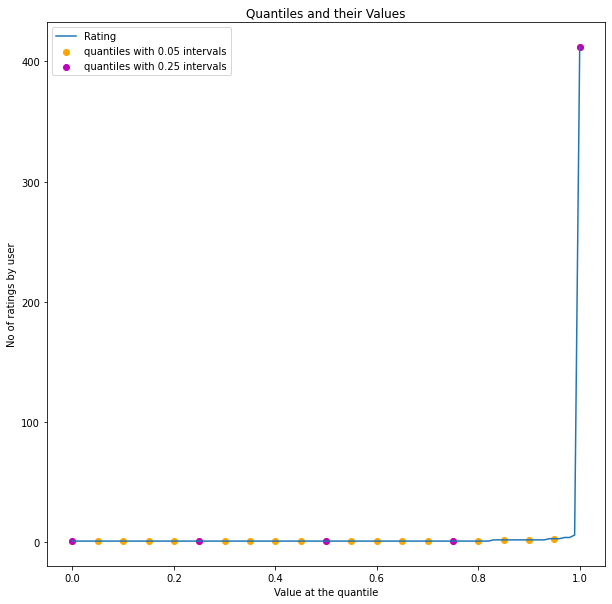

In [26]:
plt.figure(figsize=(10,10))
plt.title('Quantiles and their Values')
quantiles.plot()

plt.scatter(x=quantiles.index[::5],y=quantiles.values[::5],c='orange',label='quantiles with 0.05 intervals')
plt.scatter(x=quantiles.index[::25],y=quantiles.values[::25],c='m',label='quantiles with 0.25 intervals')
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [27]:
print('\n No of rated product more than 50 per user: {}\n'.format(
    sum(num_of_rated_products_per_user>=50)
))


 No of rated product more than 50 per user: 38



popularity based recommendation

In [28]:
new_df=electronics_data.groupby('productId').filter(lambda x:x['Rating'].count()>=50)

In [29]:
new_df.head()

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [30]:
new_df.shape

(677947, 3)

Text(0.5, 1.0, '# Ratings per Product')

Text(0.5, 0, 'product')

Text(0, 0.5, 'no of ratings per product')

[]

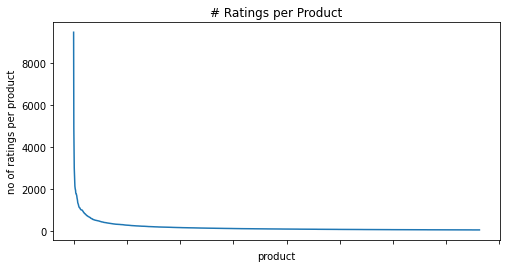

In [31]:
num_of_ratings_per_product=new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)
fig=plt.figure(figsize=plt.figaspect(.5))
ax=plt.gca()
plt.plot(num_of_ratings_per_product.values)
plt.title('# Ratings per Product')
plt.xlabel('product')
plt.ylabel('no of ratings per product')
ax.set_xticklabels([])

plt.show()

In [32]:
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [33]:
new_df.groupby('productId')['Rating'].mean().sort_values(
    ascending=False
).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [34]:
new_df.groupby('productId')['Rating'].count().sort_values(
    ascending=False
).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [35]:
ratings_mean_count=pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [36]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [37]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 432x432 with 0 Axes>

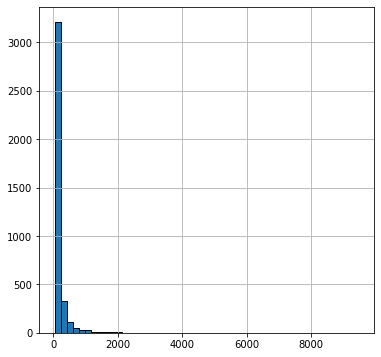

In [38]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)


<Figure size 432x432 with 0 Axes>

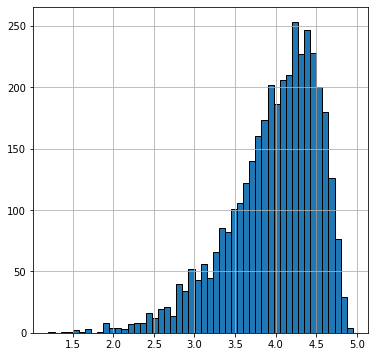

In [39]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

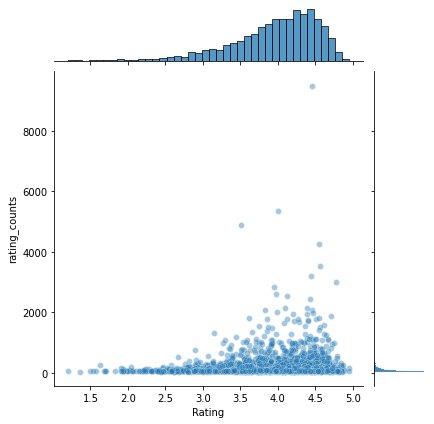

In [40]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

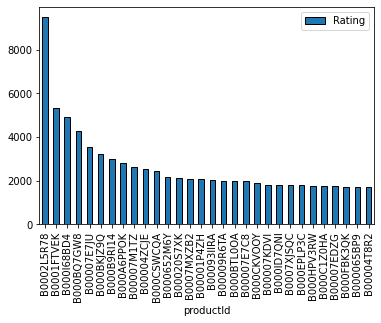

In [41]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values("Rating", ascending=False)
most_popular.head(30).plot(kind = "bar")

collaborative filtering

In [42]:
!pip3 install surprise

In [43]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [83]:
reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(new_df,reader)


In [84]:
trainset,testset=train_test_split(data,test_size=0.3,random_state=10)

In [85]:
algo=KNNWithMeans(k=5,sim_options={'name':'pearson_baseline','user_based':False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [86]:
test_pred=algo.test(testset)

In [87]:
print('Item-based Model : Test Set')
accuracy.rmse(test_pred,verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

Model based collaborative filtering system

In [88]:
new_df1=new_df.head(10000)
ratings_matrix=new_df1.pivot_table(values='Rating',index='userId',columns='productId',fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,3744295508,6301977173,7214047977,8862935293,9573212919,9575871979,9625993428,9888002198,9966694544,9983891212,9984984354,9985511476,B000001OM4,B000001OM5,B000001OMI,B000001ON6,B00000DM9W,B00000IGBF,B00000J05A,B00000J061,B00000J08Q,B00000J0D2,B00000J0D5,B00000J0D8,B00000J1EJ,B00000J1EP,B00000J1EQ,B00000J1F3,B00000J1GA,B00000J1QK,B00000J1QR,B00000J1SC,B00000J1TX,B00000J1U8,B00000J1UQ,B00000J1V3,B00000J1V5,B00000J3NF,B00000J3Q7,B00000J3UJ,B00000J434,B00000J4EY,B00000J4FS,B00000J4GE,B00000J6WY,B00000JBAT,B00000JBHP,B00000JBPB,B00000JCT8,B00000JCTO,B00000JD34,B00000JDF5,B00000JDF6,B00000JDHV,B00000JFE3,B00000JFIF,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [89]:
ratings_matrix.shape

(9832, 76)

In [90]:
X=ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,A1003EYWAQFOUG,A100LLXMXDZHJZ,A10121433FMMZNY18RWZ8,A1013OEQCVS6AR,A1013Q8NLCY56R,A101DJDPGK0Q46,A101IWCCIWQWC9,A10285OSAM1MZK,A102IUFPXVDRB6,A102L0RVI4LHH3,A102RLOGIBBDMW,A102ZABPUPNYCT,A1038957GWRBP375RU5T,A103XY7DJYZHFN,A104VHQ06KFLDT,A1058D8UFZL711,A105AZN9C8UAOJ,A105TOJ6LTVMBG,A106YUCY4SVX1D,A1077JEY0CE3BB,A1079KKA0AXSL3,A107I2HYD2JZ5G,A1089S59XSJT2T,A108LYH0NZ9919,A108UXJTIV8XXY,A10956KAP9F1CO,A109ZR833WIFQS,A10BH1JDT6SNGA,A10BOETDPAFJ4C,A10CRW7XRJBJ2G,...,AZKKZ58QBXZUA,AZKOO6TVQBDAF,AZL95QPWJDM3Y,AZM8PD2KBVXN5,AZMCJ61JS6L3X,AZMY6E8B52L2T,AZN6Z0QRMZYX8,AZNMO6T8G0ZEU,AZNVF1G1GJRR4,AZO3DZAJ8S0D9,AZODG8OG0CETL,AZOFJX627J181,AZOPTWUSS6UM0,AZOTUFIYPVNDT,AZPPZOYTNLEN0,AZPT44204EODM,AZPT6K5K0IVCT,AZPYIAOEAV3OZ,AZQ2YSCWSKWX6,AZQ9DYG38GVBR,AZQJQBJ75DHMS,AZQOWHUHXMIMS,AZQQVI9RHJYH6,AZQTJ6HUS5L2Q,AZRPGTU8A7KD5,AZS8W54PXQ01W,AZSUNAT0BRQDU,AZTC7YC8PKG39,AZTC8ZV20NO1D,AZV9WA9MNT0FB,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,5,0,4,0,0,0,5,0,0,0,0,0,...,0,0,0,5,0,0,0,0,0,5,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
X.shape

(76, 9832)

In [92]:
X.index

Index(['0972683275', '1400501466', '1400501520', '1400501776', '1400532620',
       '1400532655', '140053271X', '1400532736', '1400599997', '1400698987',
       '3744295508', '6301977173', '7214047977', '8862935293', '9573212919',
       '9575871979', '9625993428', '9888002198', '9966694544', '9983891212',
       '9984984354', '9985511476', 'B000001OM4', 'B000001OM5', 'B000001OMI',
       'B000001ON6', 'B00000DM9W', 'B00000IGBF', 'B00000J05A', 'B00000J061',
       'B00000J08Q', 'B00000J0D2', 'B00000J0D5', 'B00000J0D8', 'B00000J1EJ',
       'B00000J1EP', 'B00000J1EQ', 'B00000J1F3', 'B00000J1GA', 'B00000J1QK',
       'B00000J1QR', 'B00000J1SC', 'B00000J1TX', 'B00000J1U8', 'B00000J1UQ',
       'B00000J1V3', 'B00000J1V5', 'B00000J3NF', 'B00000J3Q7', 'B00000J3UJ',
       'B00000J434', 'B00000J4EY', 'B00000J4FS', 'B00000J4GE', 'B00000J6WY',
       'B00000JBAT', 'B00000JBHP', 'B00000JBPB', 'B00000JCT8', 'B00000JCTO',
       'B00000JD34', 'B00000JDF5', 'B00000JDF6', 'B00000JDHV', 'B00000JFE3',

In [93]:
X1=X

In [94]:
from sklearn.decomposition import TruncatedSVD
SVD=TruncatedSVD(n_components=10)
decomposed_matrix=SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [95]:
decomposed_matrix

array([[ 1.48104508e+02, -1.54573104e-01,  2.45061187e-02,
        -4.34207621e-04, -1.34153169e-01,  9.27229930e-05,
         4.60073556e-02,  1.68806709e-04,  1.93311949e-03,
        -8.20991744e-02],
       [ 6.83303134e-04,  1.28436479e+00,  1.48450667e+00,
         1.95550819e-01,  4.84144975e-04,  5.57133200e-03,
         2.56299349e-03,  2.94343068e-02,  6.14332665e+01,
         6.96133436e-01],
       [ 6.91517184e-06,  9.79181618e-02,  3.14425390e-01,
         6.63231391e-03, -7.25756355e-03, -2.78652591e-02,
         3.15374320e-02, -1.01246003e-01,  1.79857648e+00,
         7.60196737e-02],
       [ 5.68495289e-04,  7.51666339e-01,  5.44445963e-01,
         4.05093174e-02, -5.21825171e-02,  3.47743861e-03,
         1.05219823e-01,  1.09425923e-01,  4.16892583e+00,
        -9.02979443e-01],
       [ 4.88478637e-04,  8.06199141e-01,  1.03373317e+00,
        -4.01413962e-02,  6.89595797e-02,  4.98969388e-02,
        -1.21106410e-01,  3.36903387e-03,  3.81517267e-02,
         1.

In [96]:
correlation_matrix=np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [97]:
X.index[75]

'B00000K135'

In [98]:
i=X.index[75]
product_names=list(X.index)
product_ID=product_names.index(i)
product_ID

75

In [99]:
correlation_product_ID=correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [100]:
correlation_product_ID


array([ 0.11211224,  0.0442318 ,  0.0260305 ,  0.29672769, -0.74018825,
        0.08275468,  0.13997134,  0.1143795 , -0.17216853,  0.5341732 ,
        0.85175519,  0.74520727, -0.19333946, -0.83654255,  0.99313785,
       -0.64759738, -0.88470324,  0.8724205 , -0.69911117, -0.99592509,
        0.75462207,  0.45110511, -0.89746715,  0.57100816,  0.15649794,
       -0.74950832,  0.10540457, -0.84798167,  0.90180948,  0.15857709,
       -0.26646429, -0.35632457, -0.61328927,  0.8924269 ,  0.83194334,
        0.80173582,  0.91460911,  0.93521344, -0.01748394, -0.89786315,
        0.08159591, -0.51449438,  0.95860597,  0.13122719,  0.19728425,
       -0.06465441,  0.04022892,  0.52683426,  0.30908673, -0.87188496,
       -0.76804092, -0.9538345 , -0.93934629,  0.30868991, -0.8648245 ,
        0.85795043,  0.93241851,  0.16949154, -0.97913241, -0.83711273,
       -0.97757287,  0.14986471, -0.60457477,  0.90952651,  0.69997491,
       -0.12938129, -0.97853062, -0.66259814,  0.13961367, -0.53

In [101]:
Recommend=list(X.index[correlation_product_ID>0.65])

Recommend.remove(i)
Recommend[0:24]

['3744295508',
 '6301977173',
 '9573212919',
 '9888002198',
 '9984984354',
 'B00000J05A',
 'B00000J0D8',
 'B00000J1EJ',
 'B00000J1EP',
 'B00000J1EQ',
 'B00000J1F3',
 'B00000J1TX',
 'B00000JBAT',
 'B00000JBHP',
 'B00000JDHV',
 'B00000JFE3',
 'B00000JMUG',
 'B00000JSGF']

In [102]:
Recommend

['3744295508',
 '6301977173',
 '9573212919',
 '9888002198',
 '9984984354',
 'B00000J05A',
 'B00000J0D8',
 'B00000J1EJ',
 'B00000J1EP',
 'B00000J1EQ',
 'B00000J1F3',
 'B00000J1TX',
 'B00000JBAT',
 'B00000JBHP',
 'B00000JDHV',
 'B00000JFE3',
 'B00000JMUG',
 'B00000JSGF']

In [103]:
len(Recommend)

18